In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/FA-KES/FA-KES-Dataset.csv'

df = pd.read_csv(path, encoding= 'unicode_escape')
df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [2]:
print(df.shape)
df.isna().sum()

(804, 7)


unit_id            0
article_title      0
article_content    0
source             0
date               0
location           0
labels             0
dtype: int64

,article_title,labels
0,Syrian Army Kills 30 ISIL Terrorists in Aleppo...,0
1,Over 20 Daesh Terrorists Killed in SDF Operati...,1
2,US Raids on ISILs Syria Stronghold Kill 22 inc...,1
3,Syrian army says rebel bombardment of Aleppo k...,1
4,ISIS kills more than 50 in central Syria attack.,1
...,...,...
799,Bomb rockets kill 19 civilians in Syrias Alepp...,0
800,At least 100 killed after bomb hits bus convoy...,0
801,Chemical Massacre in Idlib Defies the World,1
802,Turkish military says 31 IS group militants ki...,0


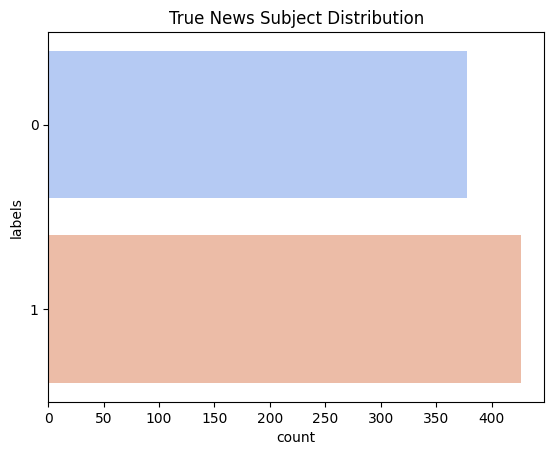

In [3]:
from sklearn.utils import shuffle

df = df[['article_title','labels']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="labels", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_title  804 non-null    object
 1   labels         804 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.7+ KB


In [5]:
df.drop_duplicates(subset=['article_title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774 entries, 0 to 802
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_title  774 non-null    object
 1   labels         774 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 18.1+ KB


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['article_title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 774
Max length of the titles: 15
Mean length of the titles: 7.91343669250646
Median length of the titles: 8.0


In [9]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(list_of_words)

sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [11]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['labels'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


Epoch 1/3
9/9 [==============================] - 18s 318ms/step - loss: 0.6922 - accuracy: 0.5287 - val_loss: 0.6890 - val_accuracy: 0.5769
Epoch 2/3
9/9 [==============================] - 1s 130ms/step - loss: 0.6908 - accuracy: 0.5360 - val_loss: 0.6853 - val_accuracy: 0.5769
Epoch 3/3
9/9 [==============================] - 1s 107ms/step - loss: 0.6898 - accuracy: 0.5360 - val_loss: 0.6854 - val_accuracy: 0.5769


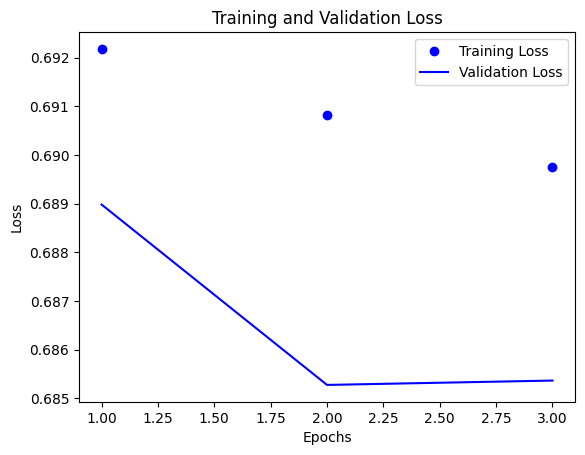

In [12]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 1s 11ms/step
CNN-BiLSTM Model Accuracy :  0.4838709677419355
Precision :  0.4838709677419355
Recall :  1.0
F1 :  0.6521739130434783
G-mean: 0.0
Training time:  20.51994490623474
Inference time:  0.8687021732330322
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.48      1.00      0.65        75

    accuracy                           0.48       155
   macro avg       0.24      0.50      0.33       155
weighted avg       0.23      0.48      0.32       155



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

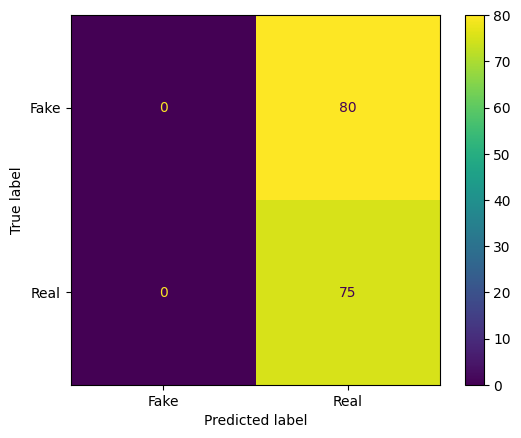

In [13]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()